## CrackMNIST Segmentation Training Notebook

### Import necessary libraries

In [1]:
import torch
from torch import optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from alive_progress import alive_bar

import crackmnist
from crackmnist import CrackMNIST
from crackmnist.nets import UNet
from crackmnist.loss import DiceLoss
from crackmnist.transforms import InputNormalization, NumpyToTensor

In [2]:
print(f"CrackMNIST v{crackmnist.__version__} @ {crackmnist.HOMEPAGE}")

CrackMNIST v0.0.1 @ https://github.com/dlr-wf/CrackMNIST/


### Define dataset parameters

CrackMNIST dataset offers 3 different sizes: "S", "M", "L" and 4 different pixel sizes: $28, 64, 128, 256$. Here we will use the smallest size "S" with lowest resolution $28 \times 28$ pixels.

In [3]:
PIXELS = 28
SIZE = "S"

### Set training hyperparameters

In [4]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
LR = 1e-4

### Select computation device

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Define data transformations

In [6]:
data_transform = transforms.Compose([
    NumpyToTensor(),
    InputNormalization(),
])
target_transform = transforms.Compose([
    NumpyToTensor(),
])

### Load dataset and create data loaders

In [7]:
train_dataset = CrackMNIST(split="train", pixels=PIXELS, size=SIZE, transform=data_transform, target_transform=target_transform)
val_dataset = CrackMNIST(split="val", pixels=PIXELS, size=SIZE, transform=data_transform, target_transform=target_transform)
test_dataset = CrackMNIST(split="test", pixels=PIXELS, size=SIZE, transform=data_transform, target_transform=target_transform)

train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

### Initialize the model, loss function, and optimizer

In [8]:
model = UNet(in_ch=2, out_ch=1, init_features=128, dropout_prob=0.2)
model = model.to(device)

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(model)

UNet(
  (inc): DoubleConv(
    (conv1): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (down1): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (doubleconv): DoubleConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

### Train the model

In [9]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    running_loss = 0.0

    with alive_bar(len(train_loader), force_tty=True) as bar:
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).to(torch.float32) / 255.)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            bar()

    train_losses.append(running_loss / len(train_loader))
    print(f"Train loss: {train_losses[-1]}")

    running_loss = 0.0
    with torch.no_grad():
        with alive_bar(len(val_loader), force_tty=True) as bar:
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                model.eval()
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1).to(torch.float32) / 255.)
                running_loss += loss.item()
                bar()

    val_losses.append(running_loss / len(val_loader))
    print(f"Val loss: {val_losses[-1]}")
    print("")

Epoch 1/10
|████████████████████████████████████████| 314/314 [100%] in 7.0s (45.16/s)     
Train loss: 0.9759176540526615
|████████████████████████████████████████| 186/186 [100%] in 1.4s (131.49/s)    
Val loss: 0.9421055768766711

Epoch 2/10
|████████████████████████████████████████| 314/314 [100%] in 7.0s (45.37/s)     
Train loss: 0.7040849024323141
|████████████████████████████████████████| 186/186 [100%] in 1.5s (130.55/s)    
Val loss: 0.4603696737879066

Epoch 3/10
|████████████████████████████████████████| 314/314 [100%] in 7.1s (44.21/s)     
Train loss: 0.3134427049737068
|████████████████████████████████████████| 186/186 [100%] in 1.5s (125.01/s)    
Val loss: 0.34525141728821623

Epoch 4/10
|████████████████████████████████████████| 314/314 [100%] in 6.9s (46.06/s)     
Train loss: 0.23870443253760126
|████████████████████████████████████████| 186/186 [100%] in 1.4s (133.50/s)    
Val loss: 0.3001722856875389

Epoch 5/10
|████████████████████████████████████████| 314/314 

### Plot training and validation loss

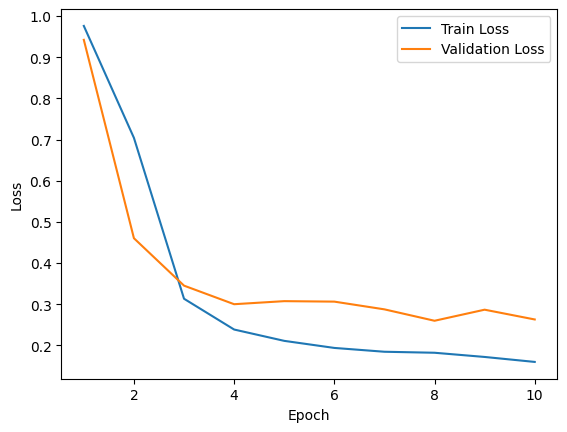

In [10]:
plt.figure()
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("training_loss.png", dpi=600)
plt.show()

### Evaluate model

In [11]:
def collect_losses(loader, description="Processing"):
    """Collect losses for each sample in the given data loader."""
    loss_list = []
    with alive_bar(len(loader), title=description, force_tty=True) as bar:
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            model.eval()
            outputs = model(inputs)
            for i in range(inputs.size(0)):
                loss = criterion(outputs[i].unsqueeze(0),
                                 targets[i].unsqueeze(0).unsqueeze(0).to(torch.float32) / 255.)
                loss_list.append(loss.item())
            bar()
    print("")
    return loss_list

# Collect losses for training, validation, and test sets
train_losses = collect_losses(train_loader, "Training")
val_losses = collect_losses(val_loader, "Validation")
test_losses = collect_losses(test_loader, "Testing")

Training |████████████████████████████████████████| 314/314 [100%] in 7.1s (44.3

Validation |████████████████████████████████████████| 186/186 [100%] in 2.8s (67

Testing |████████████████████████████████████████| 186/186 [100%] in 2.7s (69.17



### Plot loss distribution

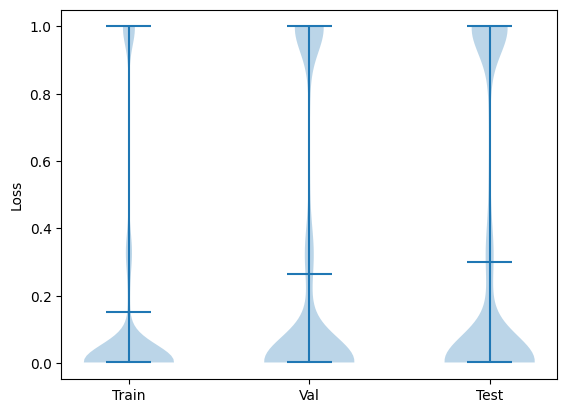

In [12]:
plt.figure()
plt.violinplot([train_losses, val_losses, test_losses], showmeans=True)
plt.xticks([1, 2, 3], ["Train", "Val", "Test"])
plt.ylabel("Loss")
plt.savefig("losses.png", dpi=600)
plt.show()

### Visualize predictions

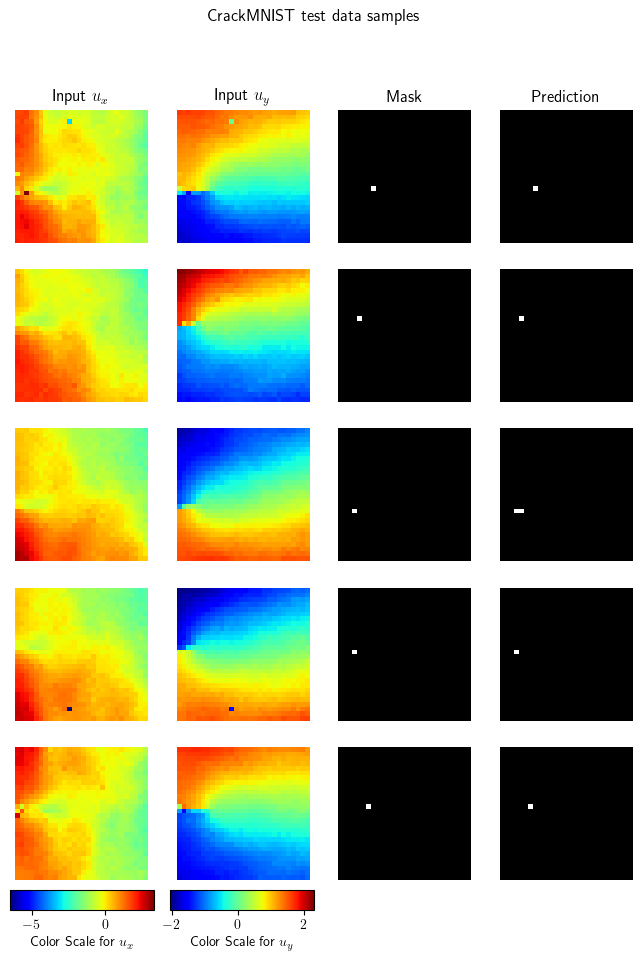

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering

# Fetch test samples
inputs, targets = next(iter(test_loader))
inputs, targets = inputs[:5], targets[:5]
inputs, targets = inputs.to(device), targets.to(device)

model.eval()
outputs = model(inputs)
outputs = (outputs > 0.5).int()

fig, axs = plt.subplots(5, 4, figsize=(8, 10), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

# Normalize each input type separately
vmin_x, vmax_x = inputs[:, 0].min().cpu(), inputs[:, 0].max().cpu()
vmin_y, vmax_y = inputs[:, 1].min().cpu(), inputs[:, 1].max().cpu()

norm_x = mcolors.Normalize(vmin=vmin_x, vmax=vmax_x)
norm_y = mcolors.Normalize(vmin=vmin_y, vmax=vmax_y)

for i in range(5):
    im_x = axs[i, 0].imshow(inputs[i, 0].cpu(), cmap='jet', norm=norm_x)
    if i == 0:
        axs[i, 0].set_title(r"Input $u_x$")
    axs[i, 0].axis('off')

    im_y = axs[i, 1].imshow(inputs[i, 1].cpu(), cmap='jet', norm=norm_y)
    if i == 0:
        axs[i, 1].set_title(r"Input $u_y$")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(targets[i].cpu(), cmap='gray')
    if i == 0:
        axs[i, 2].set_title("Mask")
    axs[i, 2].axis('off')

    axs[i, 3].imshow(outputs[i].cpu().squeeze(), cmap='gray')
    if i == 0:
        axs[i, 3].set_title("Prediction")
    axs[i, 3].axis('off')

# Create separate axes for colorbars
cbar_ax_x = fig.add_axes([0.12, 0.08, 0.18, 0.02])  # Colorbar for u_x
cbar_ax_y = fig.add_axes([0.32, 0.08, 0.18, 0.02])  # Colorbar for u_y

# Add colorbars
fig.colorbar(im_x, cax=cbar_ax_x, orientation='horizontal', label=r'Color Scale for $u_x$')
fig.colorbar(im_y, cax=cbar_ax_y, orientation='horizontal', label=r'Color Scale for $u_y$')

plt.suptitle("CrackMNIST test data samples")
plt.savefig("predictions.png", dpi=600)
plt.show()